In [2]:
%matplotlib inline
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.contrib.slim as slim

In [3]:
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
mnist = mnist_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print('train x images',(mnist.train.images.shape))
print('train y images',(mnist.train.labels.shape))
print('test images',(mnist.test.images.shape))

('train x images', (55000, 784))
('train y images', (55000, 10))
('test images', (10000, 784))


('shape size', (28, 28, 10))


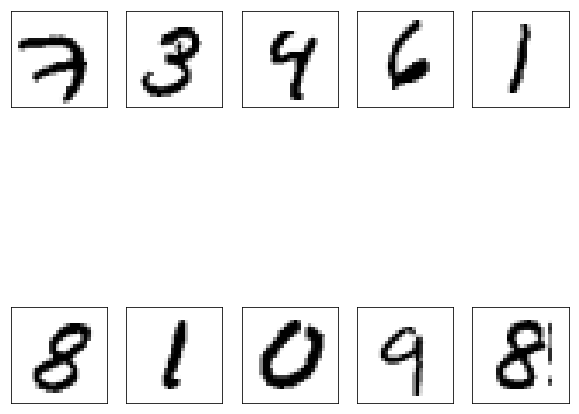

In [5]:
mnist_samples = mnist.train.images[:10,:].T.reshape(28, 28, -1)
print('shape size',mnist_samples.shape)
fig = plt.figure(figsize=(10,10))
for j in range(mnist_samples.shape[2]):
    ax = fig.add_subplot(2, 5, j+1)
    ax.imshow(mnist_samples[:,:,j], 
              cmap=matplotlib.cm.binary, interpolation='none')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

In [6]:
with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, [None, mnist.train.images.shape[1]], name='x')
    y = tf.placeholder(tf.float32, [None, mnist.train.labels.shape[1]], name='y')
    x_image = tf.reshape(x, [-1,28,28,1], name='image')

In [7]:
with slim.arg_scope(
    [slim.conv2d, slim.fully_connected],
    biases_initializer=tf.constant_initializer(0.1),
    weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
):
    out = slim.conv2d(x_image, 32, [5, 5], scope='conv1')
    out = slim.max_pool2d(out, [2, 2], scope='pool1')
    out = slim.conv2d(out, 64, [5, 5], scope='conv2')
    out = slim.max_pool2d(out, [2, 2], scope='pool2')
    out = slim.flatten(out)
    out = slim.fully_connected(out, 256, scope='fc1')
    out = slim.fully_connected(out, 10, activation_fn=None, scope='fc2')

In [8]:
with tf.name_scope('loss'):    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=out, labels=y), name='cross_entropy')
loss_summary = tf.summary.scalar('loss', loss)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [55]:
ITERS = 4000
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
output_dir = 'logs/sgd'


train_step = slim.learning.create_train_op(loss, optimizer)
init = tf.global_variables_initializer()

config = tf.ConfigProto(log_device_placement = False)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config=config)

sess.run(init)
summary_writer = tf.summary.FileWriter(output_dir, sess.graph)

In [10]:
for it in range(ITERS):

    batch_xs, batch_ys = mnist.train.next_batch(BATCH_SIZE)    
    _, loss_s = sess.run([train_step, loss_summary], feed_dict={
        x: batch_xs, y: batch_ys,
    })
    if it % 10 == 0:
        summary_writer.add_summary(loss_s, it)
        
    if it % 200 == 0:
        test_xs, test_ys = mnist.test.next_batch(128)
        acc, acc_s = sess.run([accuracy, accuracy_summary], feed_dict={
            x: test_xs, y: test_ys,
        })
        summary_writer.add_summary(acc_s, it)
        print("[%4d] Accuracy: %5.2f %%" % (it, acc*100))

[   0] Accuracy:  2.34 %
[ 200] Accuracy: 94.53 %
[ 400] Accuracy: 93.75 %
[ 600] Accuracy: 95.31 %
[ 800] Accuracy: 98.44 %
[1000] Accuracy: 94.53 %
[1200] Accuracy: 96.09 %
[1400] Accuracy: 96.88 %
[1600] Accuracy: 97.66 %
[1800] Accuracy: 96.88 %
[2000] Accuracy: 97.66 %
[2200] Accuracy: 98.44 %
[2400] Accuracy: 98.44 %
[2600] Accuracy: 100.00 %
[2800] Accuracy: 96.09 %
[3000] Accuracy: 99.22 %
[3200] Accuracy: 98.44 %
[3400] Accuracy: 98.44 %
[3600] Accuracy: 100.00 %
[3800] Accuracy: 96.09 %


In [11]:
final_acc = sess.run(accuracy, feed_dict={
    x: mnist.test.images,
    y: mnist.test.labels,
})
print('Final accuracy : %5.2f %%' % (final_acc*100))

Final accuracy : 98.63 %


In [12]:
def test_digit(sample):
    
    sample = sample[np.newaxis, ...]
    prediction = sess.run(tf.nn.softmax(out), feed_dict={x: sample})
    ans = np.argmax(prediction)

    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample.transpose().reshape(28, 28), 
              cmap=matplotlib.cm.binary,interpolation ='none')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction[0], align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid('on')

    plt.show()

    print('Answer: {}'.format(ans))

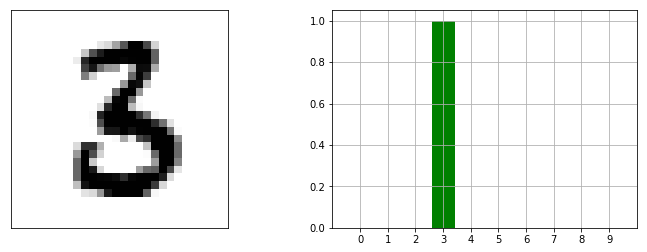

Answer: 3


In [39]:
idx = random.randint(8, mnist.test.images.shape[0])
sample = mnist.test.images[idx,:]
test_digit(sample)

In [34]:
print('True Answer: {}'.format(np.argmax(mnist.test.labels[idx])))

True Answer: 7


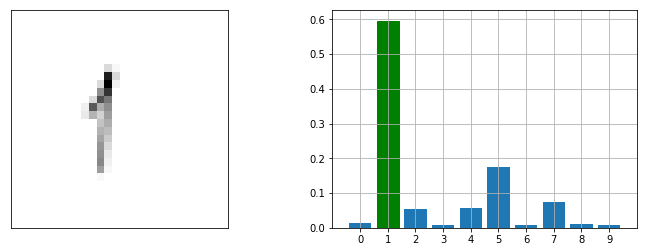

Answer: 1


In [54]:
import scipy.misc

img = scipy.misc.imread('digit.png')
img = scipy.misc.imresize(img, (28, 28))
img = 1. - img.astype(np.float32)/255.
img = np.mean(img, axis=2)
img = img.flatten()

test_digit(img)

In [ ]:
#tensorboard --logdir=/tmp/tensorflow/mnist/logs/